# Model Selection and resampling methods 

**student**: Quentin Le Roux

## Exam

We work with the database ADNI, containing information for a clinical cohort of healhty volunteers and patients with Alzheimer's disease.

In [1]:
import numpy as np
import pandas as pd

dataset = pd.read_csv('data.csv')
dataset[:10]

,Unnamed: 0,RID,Hippocampus_volume,AGE,PTGENDER,PTEDUCAT,ADAS11,FDG,DX
0,1,2,0.004200,74.3,1,16,10.67,1.369264,NL
1,16,3,0.002769,81.3,1,18,22.00,1.090790,Dementia
2,27,5,0.004312,73.7,1,16,8.67,1.297990,NL
3,46,8,0.004355,84.5,2,18,5.00,1.276278,NL
4,60,10,0.003728,73.9,2,12,12.33,1.118814,Dementia
5,65,14,0.005301,78.5,2,12,4.33,1.256990,NL
6,80,16,0.005406,65.4,1,9,10.33,1.395434,NL
7,93,21,0.005607,72.6,2,18,6.67,1.382790,NL
8,114,23,0.005298,71.7,1,14,4.00,1.364222,NL
9,221,43,0.004564,76.2,1,16,7.00,1.308406,NL


Data fields:
- RID: subject's identifier
- Hippocampus_volume = normalized volume of the brain region hippocampus
- AGE: subject's age
- PTGENDER: subject's sex (1 Male, 2 Female)
- PTEDUCAT: years of education
- ADAS11: clinical score (Alzheimer's disease assessment scale)
- FDG: measure of average brain metabolism
- DX: clinical diagnosis. In order to severity we have NL (normal), MCI (mild cognitive impairment), and Dementia

__Exercise 1.__ Estimate mean and standard deviation for the classification accuracy of the algorithms Logistic Regression and Nearest Neighbours classifier for predicting clinical diagnosis based on the variables Hippocampus_volume, AGE, PTGENDER, PTEDUCAT, ADAS11, and FDG. (use at least 1000 repetitions)

In [2]:
# Library imports

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

In [3]:
# Global Variable Declaration

features = ["Hippocampus_volume", "AGE", "PTGENDER", "PTEDUCAT", "ADAS11", "FDG"]
target = "DX"
n_repetitions = 1000

new_dataset = dataset[features+[target]]

In [4]:
# Models Declaration

LR = LogisticRegression(random_state=0, max_iter=300)
kNN = KNeighborsClassifier(n_neighbors=3)

import warnings
warnings.filterwarnings('ignore')

In [5]:
# Training & Accuracy Processing

# Declares empty array for accuracy results
computed_accuracies_LR = []
computed_accuracies_kNN = []

# Performs n_repetitions bootstrapping
for repetition in range(n_repetitions):
    # bootstraps
    bootstrapped_sample = new_dataset.sample(len(new_dataset), replace=True)
    # Splits features and target variables
    X = bootstrapped_sample[features]
    y = bootstrapped_sample[target]
    # Fits
    LR.fit(X, y)
    kNN.fit(X, y)
    # Records
    computed_accuracies_LR.append(accuracy_score(y, LR.predict(X)))
    computed_accuracies_kNN.append(accuracy_score(y, kNN.predict(X)))

In [6]:
# Computes mean and variance for the bootstrapped accuracies of the two models

boot_mean = []
boot_std = []

# Computes means
boot_mean.append(np.mean(computed_accuracies_LR))
boot_mean.append(np.mean(computed_accuracies_kNN))
# Computes stds
boot_std.append(np.std(computed_accuracies_LR))
boot_std.append(np.std(computed_accuracies_kNN))

In [7]:
# Print results

for idx, name in enumerate(["Logistic Regression", "K-NN"]):
    print(f"\n#### {name} ####")
    print(f"Mean accuracy: {boot_mean[idx]}")
    print(f"St.Dev. accuracy: {boot_std[idx]}")


#### Logistic Regression ####
Mean accuracy: 0.6763453744493393
St.Dev. accuracy: 0.014953254959370922

#### K-NN ####
Mean accuracy: 0.8937215859030837
St.Dev. accuracy: 0.007691489873630406


<u>Results:</u>

| Model | Mean Accuracy | Accuracy Standard Deviation | 
| :--- | --- | --- |
| Logistic Regression (300 max iterations) | 0.67 | 0.02 |
| K-Nearest Neighbors (k = 3) | 0.89 | 0.01 | 

<hr>

__Exercise 2.__ Use boostrap to estimate the significance of the difference between the accuracy of Logistic regression and the one of Nearest Neighbours.

In [8]:
# Library Imports

import copy

In [9]:
# Reuses the boostrapped accuracies computed in exercise 1

accuracies_LR = computed_accuracies_LR.copy()
accuracies_kNN = computed_accuracies_kNN.copy()

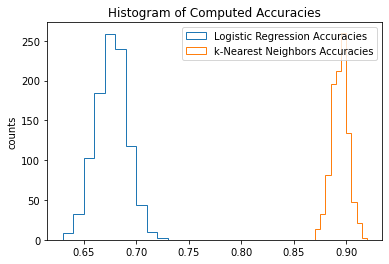

In [10]:
# Visualizes the distribution of the accuracies

plt.hist(accuracies_LR, 10, histtype='step', label = 'Logistic Regression Accuracies')
plt.hist(accuracies_kNN, 10, histtype='step', label = 'k-Nearest Neighbors Accuracies')
plt.title('Histogram of Computed Accuracies')
plt.ylabel('counts')
plt.legend()
plt.show()

<u>Observations:</u>

Our first observation is that the accuracies computed for the logistic regression and k-nearest neighbors models are fairly different. Our intuition is that the two distribution will be significantly different

In [11]:
# Function declarations

def compute_t(x, y):
    """
    Computes the statistics t for hypothesis testing 
    between two distributions x and y
    """
    # Variable declaration
    n_x = len(x)
    n_y = len(y)
    # Mean and Variance calculation
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    sigma2_x = np.var(x)
    sigma2_y = np.var(y)
    return (mean_x-mean_y)/np.sqrt(sigma2_x/n_x+sigma2_y/n_y)

def compute_centered_data(x, y):
    """
    Computes the centered data of two distributions x and y
    """
    # Computation of statistic t
    t_obs = compute_t(x,y)
    # Computation for centering the distributions
    z = np.concatenate([x, y])
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    # Translating the data around avg(z)
    x_tilde = x - mean_x + np.mean(z)
    y_tilde = y - mean_y + np.mean(z)
    return x_tilde, y_tilde
    
def bootstrapped_t_calculate(x, y, repetitions):
    """
    Computes the bootstrapped t statistics for two distributions x and y
    """
    # Variable declaration
    n_x = len(x)
    n_y = len(y)
    t_bootstrapped = []
    # Computation of centered data
    x_tilde, y_tilde = compute_centered_data(x, y)
    # Centered data concatenation
    z_tilde = np.concatenate([x_tilde, y_tilde])
    # Generation of B bootstrapped samples
    bootstrapped_samples = np.random.choice(z_tilde, 
                                            (repetitions, n_x + n_y), 
                                            replace=True)
    # computation of the t statistic for each bootstrapped sample
    for i in range(repetitions):
        x_simulated = bootstrapped_samples[i, :n_x]
        y_simulated = bootstrapped_samples[i, n_x:]
        t_bootstrapped.append(compute_t(x_simulated, y_simulated))
    return t_bootstrapped

def print_null_distribution(t_obs, t_boot):
    """
    Plots the null hypothesis distribution
    """
    plt.figure(figsize=(18,8))
    plt.hist(t_boot, 10, histtype='step')
    plt.title('Null distribution')
    plt.axvline(x=t_obs)
    plt.show()
    
def hypothesis_testing(t_obs, t_boot, repetitions):
    """
    Computes the hypothesis testing between an observed statistic t
    and its bootstrapped counterpart
    """
    # Computes the significance of our test
    boot_stat = np.sum(np.abs(t_obs)>np.abs(t_boot))/repetitions
    confidence_interval = np.quantile(t_boot, [0.025, 0.975])
    # Prints results
    print(f"The 2-sided bootstrapped p-value (significance of the test) is: {1-boot_stat}")
    print(f"The 95% coinfidence interval for the null hypothesis: {confidence_interval}")
    print(f"Observed statistic: {t_obs}")
    if t_obs >= confidence_interval[0] and t_obs <= confidence_interval[1]:
        print("\nWe cannot reject the null hypothesis.")
        print("The accuracy mean for the Logistic Regression model is the same " + 
              "as for the k-Nearest Neighbor model.")
    else:
        print("\nWe can reject the null hypothesis.")
        print("The accuracy mean for the Logistic Regression model is different " + 
              "from the k-Nearest Neighbor model.")

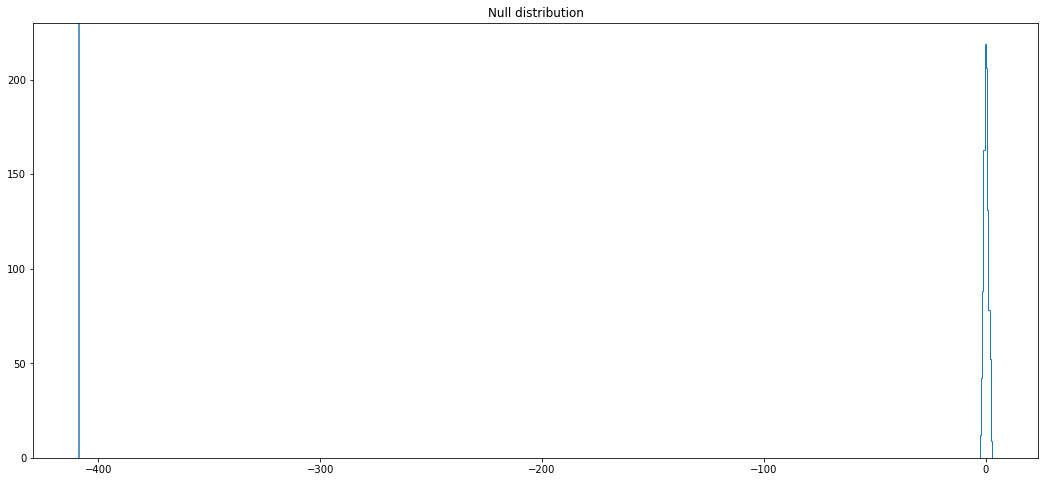

In [12]:
# Computes the observed t statistic and its bootstrapped counterpart from the accuracies
# computed in exercise 1 (via a bootstrapped process)

t_observed = compute_t(accuracies_LR, accuracies_kNN)
t_bootstrapped = bootstrapped_t_calculate(accuracies_LR, accuracies_kNN, n_repetitions)
print_null_distribution(t_observed, t_bootstrapped)

In [13]:
# Performs hypothesis testing

hypothesis_testing(t_observed, t_bootstrapped, n_repetitions)

The 2-sided bootstrapped p-value (significance of the test) is: 0.0
The 95% coinfidence interval for the null hypothesis: [-1.87978453  2.08883103]
Observed statistic: -408.79343415871057

We can reject the null hypothesis.
The accuracy mean for the Logistic Regression model is different from the k-Nearest Neighbor model.


<u>Results:</u>

Bootstrapping 1000 times from the accuracies we computed in exercise 1, we find that our intuition is confirmed: the distributions of the accuracies for the two models (Logistic Regression and k-Nearest Neighbors) are significantly different.

<hr>

__Exercise 3__. Compute a 95% confidence interval for the median years of education in the group Dementia, and in the group healthy (NL). Are the median significantly different?  

In [14]:
# Global Variable Declaration

reduced_dataset = dataset[["PTEDUCAT", "DX"]]
dementia_set = reduced_dataset[reduced_dataset['DX'] == "Dementia"].drop(columns=["DX"])
healthy_set = reduced_dataset[reduced_dataset['DX'] == "NL"].drop(columns=["DX"])

alpha = .05
threshold = alpha/2 * n_repetitions

In [15]:
# Function declarations

def generate_bootstrap(data, repetitions):
    """
    Generates bootstrapped sets from a dataset, given a number of repetitions
    """
    boot = np.random.choice(data, 
                            size=[len(data), repetitions],
                            replace = True)
    return boot

def confidence_interval(bootstrapped_estimator, repetitions, 
                        threshold, alpha,
                        patient = "neurotypical patients"):
    """
    Calculates a confidence interval for a given bootstrapped estimator
    """
    # Calculating lower and upper quantiles
    print(threshold, repetitions-threshold)
    low = np.sort(bootstrapped_estimator)[int(threshold)]
    up = np.sort(bootstrapped_estimator)[int(repetitions-threshold)]
    print(f"The {100-alpha}% confidence interval for the median number of years of education of " + 
          f"{patient} is:\n",
          f"[{low}, {up}]")
    return low, up

def hypothesis_testing_v2(x, y, n_repetitions):
    """
    Computes the observed t statistic and its bootstrapped counterpart from the medians
    """
    n = len(x)
    m = len(y)
    # Computes the observed statistic
    t_stat = compute_t(x,y)
    # Concatenates data for centering the distributions
    z = np.concatenate([x,y])
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    # Translates the data around an average avg(z)
    x_tilde = x - mean_x + np.mean(z)
    y_tilde = y - mean_y + np.mean(z)
    # Concatenates the centered data and sample from it
    z_tilde = np.concatenate([x_tilde, y_tilde])
    # We generate B samples 
    b_sample = np.random.choice(z_tilde, (n_repetitions, n+m), replace=True)
    # For each pair of bootstrap samples, computes the associated statistic 
    t_bootstrap = []
    for i in range(n_repetitions):
        x_simulated = b_sample[i,:n]
        y_simulated = b_sample[i,n:]
        t_bootstrap.append(compute_t(x_simulated, y_simulated))
    # Plots the null hypothesis distribution
    plt.hist(t_bootstrap, 25, histtype='step')
    plt.title('Null distribution')
    plt.axvline(x = t_stat)
    plt.show()
    # Computes the significance of our test
    bootstrap_stat = np.sum(np.abs(t_stat)>np.abs(t_bootstrap))/n_repetitions
    print('The bootstrap significance of the test is: ' + str(1-bootstrap_stat))


In [16]:
# Bootstraps datasets

boot_dementia = generate_bootstrap(dementia_set["PTEDUCAT"], n_repetitions)
boot_healthy = generate_bootstrap(healthy_set["PTEDUCAT"], n_repetitions)

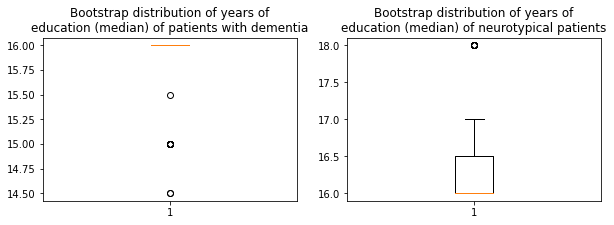

In [17]:
# Visualizes the distribution of the medians

boot_median_dementia = np.median(boot_dementia, 0)
boot_median_healthy = np.median(boot_healthy, 0)

plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
plt.boxplot([boot_median_dementia])
plt.title('Bootstrap distribution of years of\neducation (median) of patients with dementia')
plt.subplot(1,2,2)
plt.boxplot([boot_median_healthy])
plt.title('Bootstrap distribution of years of\neducation (median) of neurotypical patients')
plt.show()

In [18]:
# Computation of a 95% confidence interval for the bootstrapped median

low, up = confidence_interval(boot_median_healthy, n_repetitions, threshold, alpha)
low, up = confidence_interval(boot_median_dementia, n_repetitions, threshold, alpha)

25.0 975.0
The 99.95% confidence interval for the median number of years of education of neurotypical patients is:
 [16.0, 17.0]
25.0 975.0
The 99.95% confidence interval for the median number of years of education of neurotypical patients is:
 [16.0, 16.0]


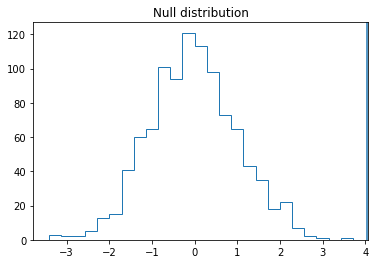

The bootstrap significance of the test is: 0.0


In [19]:
hypothesis_testing_v2(healthy_set["PTEDUCAT"], dementia_set["PTEDUCAT"], n_repetitions)

<u>Observations:</u>

We can reject the hypothesis that the two median are similar. 

Based on the bootstrapped significance, we can say that the median for the year of educations for the patients with dementia is significantly different from the median of the neurotypical patients. 

<hr>

__Exercise 4.__ Use the information criteria to decide what is the best polynomial model that explains the relatioship between FDG (predictor) and ADAS11 (target) in the group MCI? And in the group NL? 

**Assumption**: We choose to rely on the AIC, AICc and BIC as information criteria.

In [20]:
# Global variable declaration

new_dataset = dataset[["FDG", "ADAS11", "DX"]]

MCI_set = new_dataset[new_dataset['DX'] == "MCI"].drop(columns=["DX"])
NL_set = new_dataset[new_dataset['DX'] == "NL"].drop(columns=["DX"])

degrees = 10

In [21]:
# Function Declaration

def Gaussian_loglik(x,y,w,sigma2):
    """
    Computes the Gaussian log-likelihood
    """
    N = len(y)
    ll = -N/2 * np.log(2*np.pi*sigma2) - 1/(2*sigma2) * np.sum((y-x.dot(w.T))**2)
    return ll

def fit_poly(x,y,d):
    """
    Fits a polynomial model
    """
    w_ml = np.linalg.solve(x.T.dot(x),x.T.dot(y))
    w_ml.reshape(1,(len(w_ml)))
    sigma2_ml = np.mean((y-x.dot(w_ml.T))**2)
    return w_ml, sigma2_ml

def pseudo_gridsearch(x, y, d):
    """
    Performs a pseudo-grid search on a polynomial model over a given
    degree range
    """
    loglik = []
    AIC = []
    AICc = []
    BIC = []
    for d in range(1,d):
        x_poly = np.array([x**i for i in range(d)]).T
        w_ml, sigma2_ml = fit_poly(x_poly,y,d)
        loglik.append(Gaussian_loglik(x_poly,y,w_ml,sigma2_ml))
        dev = -2*np.array(Gaussian_loglik(x_poly, y, w_ml, sigma2_ml))
        AIC.append(dev+2*len(w_ml))
        BIC.append(dev+2*len(w_ml)*np.log(len(x)))
        AICc.append(dev+2*len(w_ml) + 2*d + 2.*d*(d+1)/(x.shape[0]-d-1))
    return AIC, AICc, BIC

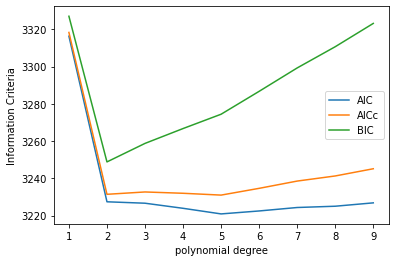

In [22]:
# Computes polynomial model fit results for the MCI patients

AIC, AICc, BIC = pseudo_gridsearch(MCI_set["FDG"], MCI_set["ADAS11"], degrees)

plt.plot(range(1,degrees), AIC, label = "AIC")
plt.ylabel('Information Criteria')
plt.plot(range(1,degrees), AICc, label = "AICc")
plt.plot(range(1,degrees), BIC, label = "BIC")
plt.xlabel('polynomial degree')
plt.legend()
plt.show()

<u>Observations for MCI patients:</u>

We see that the AIC find the best polynomial model to be the one with 5 degrees. However, we also see that the AICc (corrected version of the AIC) and the BIC favor the model with only 2 degress. We recall:

> The rule of thumb for using AICc is when the ratio $\frac{N}{N_{parameters}}$ is less than 40, and in general, AICc is always preferred to AIC.

Since AICc is always prefered in general to AIC and that the BIC seems to side with the AICc, we should prefer using a simpler model that only has 2 degrees.

Now we repeat the procedure with the neurotypical patients:

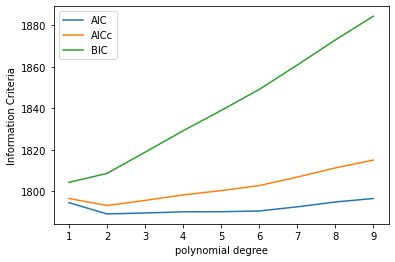

In [23]:
# Computes polynomial model fit results for the NL patients

AIC, AICc, BIC = pseudo_gridsearch(NL_set["FDG"], NL_set["ADAS11"], degrees)

plt.plot(range(1,degrees), AIC, label = "AIC")
plt.ylabel('Information Criteria')
plt.plot(range(1,degrees), AICc, label = "AICc")
plt.plot(range(1,degrees), BIC, label = "BIC")
plt.xlabel('polynomial degree')
plt.legend()
plt.show()

<u>Observations for NL patients:</u>

We find that the BIC is a constantly increasing curve while the AIC and AICc seem to favor a model with 2 degrees. As such, we would favor, like with the MCI set, a polynomial model with 2 degrees.

__Exercise 5.__ Repeat Exercise 4 by using leave one out, and compare the results.

In [24]:
# Import library

from sklearn.model_selection import LeaveOneOut

In [25]:
# Function Declaration

def pseudo_gridsearch_using_LOO(data, d):
    """
    Performs a pseudo-grid search on a polynomial model over a given
    degree range using the leave-one-out
    """
    # Sets 
    training_deviance = []
    testing_deviance = []
    training_sd = []
    testing_sd = []

    N = 100
    max_d = 10

    for d in range(1,d):
        training_ll = []
        testing_ll = []
        loo = LeaveOneOut()
        for train, test in loo.split(data):
            # Selects the left out 
            x_train = data.iloc[train]["FDG"]
            x_test = data.iloc[test]["FDG"]
            y_train = data.iloc[train]["ADAS11"]
            y_test = data.iloc[test]["ADAS11"]
            # Fits the polynomial model
            x_train_poly = np.array([x_train**i for i in range(d)]).T
            w_ml, sigma2_ml = fit_poly(x_train_poly,y_train,d)
            training_ll.append(Gaussian_loglik(x_train_poly,y_train,w_ml,sigma2_ml))
            # Tests
            x_test_poly = np.array([x_test**i for i in range(d)]).T
            testing_ll.append(Gaussian_loglik(x_test_poly,y_test,w_ml,sigma2_ml))
        # Records
        training_deviance.append(np.mean(-2*np.array(training_ll)))
        testing_deviance.append(np.mean(-2*np.array(testing_ll)))
        training_sd.append(np.std(-2*np.array(training_ll)))
        testing_sd.append(np.std(-2*np.array(training_ll)))

    # Reformats
    training_deviance = np.array(training_deviance)
    testing_deviance = np.array(testing_deviance)
    training_sd = np.array(training_sd)
    testing_sd = np.array(testing_sd)

    plt.title('Training and testing deviance')
    plt.plot(range(1,max_d), training_deviance, color='blue', alpha = 0.3)
    plt.plot(range(1,max_d), testing_deviance, color='red', alpha = 0.3)
    plt.fill_between(range(1,max_d), training_deviance - 2*training_sd, 
                     training_deviance + 2*training_sd, 
                     label = 'training', facecolor='blue', alpha=0.2,)
    plt.fill_between(range(1,max_d), testing_deviance - 2*testing_sd, 
                      testing_deviance + 2*testing_sd, 
                     label = 'testing', facecolor='red', alpha=0.2,)
    plt.ylabel('Deviance')
    plt.xlabel('polynomial degree')
    plt.legend()
    plt.show()

    plt.title('training/testing deviance difference')
    plt.plot(range(1,max_d), 
             [training_deviance[i] - testing_deviance[i] 
              for i in range(len(testing_deviance))], 
             label = 'deviance difference')
    plt.plot(range(1,max_d), -2* np.array(range(1,max_d)), label = 'y = -2*x')
    plt.ylabel('difference')
    plt.xlabel('polynomial degree')
    plt.legend()
    plt.show()

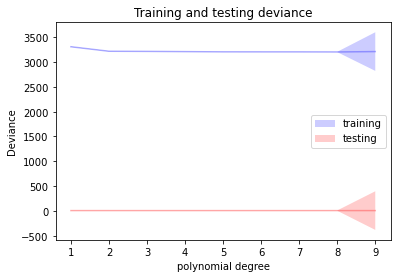

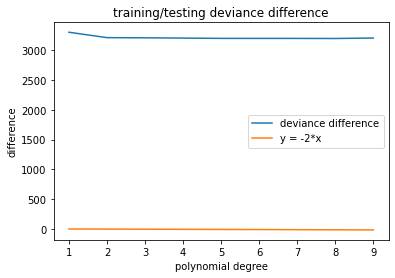

In [26]:
# Performs the pseudo grid-search using the Leave-One-Out Method on the MCI set

pseudo_gridsearch_using_LOO(MCI_set, degrees)

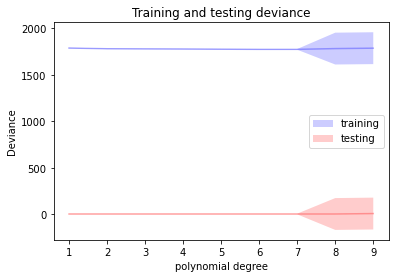

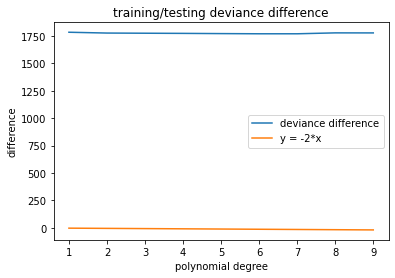

In [27]:
# Performs the pseudo grid-search using the Leave-One-Out Method on the NL set

pseudo_gridsearch_using_LOO(NL_set, degrees)

<u>Observations:</u>

As of now, we see that using a leave-one-out method does not yield satisfying results compared to using the information criteria as we cannot find deviance or differences between the two models. The only element we can find is a drop in deviance on the MCI set once we cross the 2-degree threshold (which is something we would expect given the results of exercise 4).

__Exercise 6.__ What is the best combination of variables (excluded DX) for predicting ADAS11 with a linear model?

In [28]:
# library imports

import itertools

In [29]:
# Global variable declaration

target = dataset[["ADAS11"]]
features = dataset.drop(columns=["ADAS11", "DX"])

max_number_of_columns = len(features.columns)

In [30]:
# Function Declaration

# Supporting functions for model fitting
def Gaussian_loglik(x,y,w,sigma2):
    N = len(y)
    ll = -N/2 * np.log(2*np.pi*sigma2) - 1/(2*sigma2) * np.sum((y-x.dot(w))**2)
    return ll

def fit_poly(x,y):
    w_ml = np.linalg.solve(x.T.dot(x),x.T.dot(y))
    w_ml.reshape(1,(len(w_ml)))
    sigma2_ml = np.mean((y-x.dot(w_ml))**2)
    return w_ml, sigma2_ml

def compute_comparative_table(features, target, max_number_of_columns):
    """
    Computes a comparative table given data
    """
    AIC = []
    AICc = []
    BIC = []
    model = []
    ll = []
    coef = []
    sigma2 = []

    # For each number of parameters in the model
    for n_elements in range(1,10):
        # For each combination of variables
        for indices in itertools.combinations(range(max_number_of_columns), n_elements):

            # Store the indices corresponding to the parameters
            model.append(indices)

            # Fit the model

            x_train = features.values[:,indices].reshape(features.values.shape[0],n_elements)
            w_ml, sigma2_ml = fit_poly(x_train, target.values)

            # compute the log-likelihhod
            training_ll = Gaussian_loglik(x_train,target,w_ml,sigma2_ml)

            # store the coefficients
            coefficients = np.zeros(max_number_of_columns)
            coefficients[[indices]] = w_ml.T        
            coef.append(coefficients)
            sigma2.append(sigma2_ml)

            # store all the metrics
            ll.append(float(-training_ll))
            AIC.append(float(-2*training_ll + 2*n_elements))
            AICc.append(float(-2*training_ll + 2*n_elements + 2.*n_elements*(n_elements+1)/(features.values.shape[0]-n_elements-1)))
            BIC.append(float(-2*training_ll + 2*n_elements*np.log(features.values.shape[0])))

    results = pd.DataFrame({'model': model, 'AIC': AIC, 'AICc': AICc, 'BIC' :BIC, 
                            'neg_loglik' : ll, 'coef' : coef, 'sigma2' : sigma2})  
    return results

In [31]:
# Computes results

results = compute_comparative_table(features, target, max_number_of_columns)

In [32]:
# Process table

results.sort_values('AIC', ascending = True, inplace = True)
results.reset_index(inplace = True)
model_comparison = results[['model', 'AIC', 'AICc', 'BIC', 'neg_loglik']]

fitted_models = results[['model', 'coef', 'sigma2']]

In [33]:
# Prints best results

differences_wrt_minimum = model_comparison.AIC - model_comparison.AIC[0]
model_comparison.insert(len(model_comparison.columns), 'd', differences_wrt_minimum)
model_comparison[:10]

,model,AIC,AICc,BIC,neg_loglik,d
0,"(0, 1, 2, 3, 4, 5, 6)",7263.717611,7263.816990,7348.199042,3624.858805,0.000000
1,"(0, 2, 3, 4, 5, 6)",7270.892307,7270.966775,7343.304962,3629.446153,7.174696
2,"(0, 1, 2, 3, 5, 6)",7272.046014,7272.120482,7344.458669,3630.023007,8.328403
3,"(0, 1, 2, 3, 4, 6)",7275.641804,7275.716272,7348.054459,3631.820902,11.924193
4,"(0, 1, 3, 4, 5, 6)",7277.684523,7277.758991,7350.097178,3632.842262,13.966913
5,"(1, 2, 3, 4, 5, 6)",7279.691723,7279.766191,7352.104378,3633.845861,15.974112
6,"(0, 2, 3, 5, 6)",7280.415060,7280.468205,7340.758940,3635.207530,16.697450
7,"(0, 1, 2, 3, 6)",7281.158384,7281.211528,7341.502263,3635.579192,17.440773
8,"(0, 1, 3, 5, 6)",7281.425282,7281.478426,7341.769161,3635.712641,17.707671
9,"(0, 2, 3, 4, 6)",7282.207360,7282.260505,7342.551240,3636.103680,18.489750


In [34]:
features.columns

Index(['Unnamed: 0', 'RID', 'Hippocampus_volume', 'AGE', 'PTGENDER',
       'PTEDUCAT', 'FDG'],
      dtype='object')

<u>Observations:</u>

The best combination of features to predict ADAS11 is "Unnamed:0", "RID", "Hippocampus_volume", "AGE", "PTGENDER", and "PTEDUCAT".

<hr>

__Exercise 7.__ Consider only the healtiest subjects for which diagnosis == NL and ADAS11 < 5. Compare the performance of the classifiers of Exercise 1 for discriminating this group from the group MCI.

<u>Observations:</u>

<hr>

__Exercise 8.__ Is it true that a model with the lowest AIC is the best one? 

It is not always the best one. We recall the general rule of thumb we cited in exercise 4:
    
> The rule of thumb for using AICc is when the ratio $\frac{N}{N_{parameters}}$ is less than 40, and in general, AICc is always preferred to AIC.

The lowest AIC might not correspond to the lowest AICc for instance. 

Furthermore, we may want to penalise some terms (such as the increase of the likelihood by the number of parameters used to fit the model). We would then use the Bayesian Information Criterion (BIC) as the penalty term is much larger for BIC than for AIC.

<hr>

__Exercise 9.__ Explain the concept of bias-variance decomposition

The stability of a model with respect to the variation that is latent in the data consistently decreases as the model's complexity increases. This leads to a risk of overfitting, and therefore losing the generalization we want to yield from the model (i.e. high sensitivity to the training data will decrease the ability of the model to apply to unseen data (e.g. test)).

As seen during the class:

> This aspect is formalized in statistics as the __bias-variance trade-off__. To illustrate this concept we follow a derivation adapted from the book _Pattern Recognition and Machine Learning_ (C.M. Bishop, Springer, 2006).

The bias corresponds to the difference between the average predictions over the possible datasets and our objective function. Meanwhile, the variance measures the variability in the predictions given the data from the possible datasets.

Bias and Variance are two of the three elements that compose the loss of a model. We recall from the course: 

> $$\textbf{Loss}  =  \mathbf{Noise} + \mathbf{Bias}^2 + \mathbf{Variance},$$
> 
> where,
> 
> \begin{align*}
> \mathbf{Noise}    &=  \int_x Var(y | x) \, p(x)dx\\
> \mathbf{Bias}^2   &= \int_x (f(x) - \mathbf{E}_\mathcal{D}[\hat{y\,}])^2 \, p(x)dx\\
> \mathbf{Variance} &=  \int_x \mathbf{E}_\mathcal{D}[(\mathbf{E}_\mathcal{D}[\hat{y\,}] -\hat{y\,})^2] \, p(x)dx
> \end{align*}

As such, there is a trade-off to be had between the two (we can't do anything about noise):

As our model compexity increases, we expect the bias to decrease (we are fitting the model more closely to the data) at the expense of the variance (as we lose some of the generalization power of the model). 

The goal of the trade-off is to find the minimum point achievable with regards to our model parameters where the mix bias+variance is minimized.

<hr>

__Exercise 10.__ Generate synthetic data of 20 samples with a polynomial relationship of degree 3, and arbitrary noise. Train polynomial models of degree 1, 2, and 3, and 5. Compute AIC and BIC for these models. Comment the results. 

In [35]:
# Library Imports

from sklearn.preprocessing import PolynomialFeatures

In [40]:
# Global variable declaration

x_min = -5
x_max = 5
N_samples = 20
degrees = [1,2,3,5]

In [46]:
# Function declaration

def f(x):
    return(np.sin(1*x))

def sample_data_batch(x_min,x_max, N_samples):
    ## The x-data is fixed (no variability here)
    X = np.linspace(x_min,x_max,N_samples)
    noise_level = 0.5
    noise = noise_level * np.random.randn(N_samples)
    return [X,f(X) + noise]

def fit_poly(x,y,d):
    """
    Fits a polynomial model
    """
    w_ml = np.linalg.solve(x.T.dot(x),x.T.dot(y))
    w_ml.reshape(1,(len(w_ml)))
    sigma2_ml = np.mean((y-x.dot(w_ml.T))**2)
    return w_ml, sigma2_ml

In [47]:
# Data Generation

x, y = sample_data_batch(x_min, x_max, N_samples)
poly = PolynomialFeatures(3)
x_poly = poly.fit_transform(x.reshape(-1,1))

In [56]:
AIC = []
BIC = []

## Training and testing error for increasing polynomial degree
for degree in degrees:
    ## Model declaration
    w_ml, sigma2_ml = fit_poly(x_poly, y, degree)
    # compute the log-likelihhod
    training_ll = Gaussian_loglik(x_poly, y, w_ml, sigma2_ml)
    # store all the metrics
    AIC.append(float(-2*training_ll + 2*N_samples))
    BIC.append(float(-2*training_ll + 2*N_samples*np.log(len(y))))

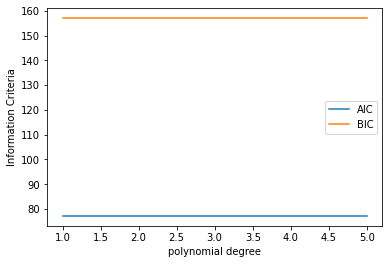

In [57]:
# Plots

plt.plot(degrees, AIC, label = "AIC")
plt.ylabel('Information Criteria')
plt.plot(degrees, BIC, label = "BIC")
plt.xlabel('polynomial degree')
plt.legend()
plt.show()

<u>Observations:</u>

We don't see any difference in information criterion for these results (which is not expected and should be further explored). It is very likely there is an error in the implementation but due to lack of time, this will not be solved here.

<hr>

__Exercise 11.__ From Exercise 1 compute the probability that the average prediction accuracy of Logistic classifier is greater than 0.66.

In [67]:
# Library Import

import seaborn as sns

In [71]:
# Compute the probability via quantiles

for i in range(1, 1000):
    if np.quantile(accuracies_LR, i/1000)>= 0.66:
        print("Based on a bootstrapping approach, the probability that " +
              "the average prediction accuracy of the Logistic Classifier " +
              f"is greater than 0.66 is: {100-i/10}%")
        break

Based on a bootstrapping approach, the probability that the average prediction accuracy of the Logistic Classifier is greater than 0.66 is: 85.5%


Text(0.5, 1.0, 'Probability Density Function of the bootstrapped average accuracies for the logistic regression')

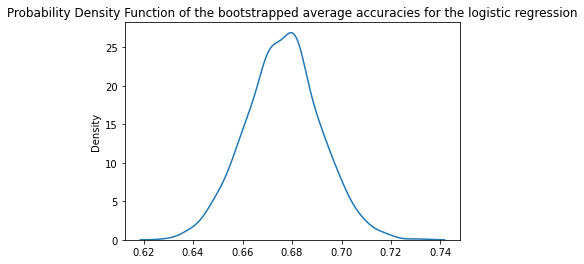

In [69]:
sns.kdeplot(accuracies_LR).set_title(
    "Probability Density Function of the bootstrapped average accuracies for the logistic regression"
)

<u>Observations:</u>

visually, we seem to confirm our approximation that 85.5% of our average prediction will be above 0.66.

<hr>

__Exercise 12.__ Explain when the use of the area under the curve (AUC) can lead to biased estimation of the accuracy.

The use of the AUC can lead to a biased estimation of the accuracy when the dataset is imbalanced (between classes for instance) as accuracy may not capture any concept of precision or recall. In such a case, the use of a PR curve might be prefered over the AUC.

We recall from the course:

> The problem of unbalanced data is critical when assessing a classification metric. We recall that the accuracy is defined as: 
>
> $$ ACC = \frac{\mbox{True Positives} + \mbox{True negatives}}{\mbox{Total sample size}}.$$
>
> If there is unbalance in the data, for example the positive class represents 90% of the population, a classifier predicting constantly positive will lead to an accuracy of $.9$ without however correctly predicting any of the samples of the negative class. This may represent a serious issue, for example in _fraud detection_ problems, where we are interested in predicting classes which are very rare (the frauds).
